In [102]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from scipy import constants
from scipy import signal
import skrf as rf

In [103]:
%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['figure.figsize'] = [5, 3.5]

# Analysis for a transmission line with constant impedance

In a transmission line with constant charactaritic impedance, we have

$$\Gamma(\omega, z)=\Gamma(\omega, 0)e^{2j\omega\sqrt{\epsilon\mu}z}$$

# $\epsilon(z)$ synthesis from $\Gamma(\omega, z)\Big|_{z=0}$

The line is as follows

- L = 200 $\mu$
- $Z_L = 70 + j\omega 3\times10^9 \Omega$
- $R_g=50 \Omega$
- W = S = 20 $\mu$
- $L_{strip} = 3 \mu$
- $S_{strip} = 1\mu$
- $W_{strip} = 30\mu$

In [104]:
L = 200e-6
W = 20e-6
S = W
Lstrip = 3e-6
Sstrip = 1e-6
Wstrip = 30e-6

Rg = 50 # omega

We have
$$\Gamma(\omega, z)=\frac{Z_L-Z(\omega, z)}{Z_L+Z(\omega,z)}$$

We also want that $Z(\omega, L) = Z_L$

Assume we are given that $\Gamma(\omega, z)\Big|_{z=0}$ is a low pass chebyshev's filter

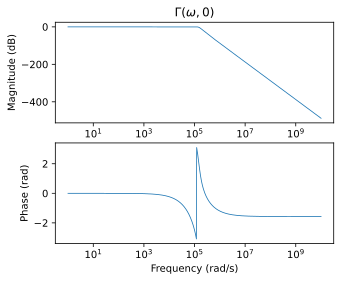

In [105]:
# Define filter parameters
order = 5
cutoff_freq = 1e5
ripple = 1e-3  # in dB
# Create filter
b, a = signal.cheby1(order, ripple, cutoff_freq, 'low', analog=True)
Gamma0 = signal.TransferFunction(b, a)
w = np.logspace(0, 10, num=1000)
# Plot frequency response
w, Gamma0 = signal.freqresp(Gamma0, w)
plt.subplot(2, 1, 1)
plt.semilogx(w, 20 * np.log10(abs(Gamma0)))
plt.title('$\Gamma(\omega, 0)$')
plt.ylabel('Magnitude (dB)')

plt.subplot(2, 1, 2)
plt.semilogx(w, np.angle(Gamma0))
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase (rad)')
plt.show()

Now that $\omega$ is defined, we can define $Z_L$  


In [106]:
ZL = 70 + 3e2j/w

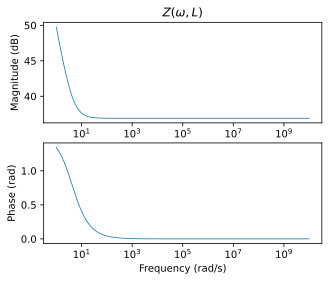

In [107]:
plt.subplot(2,1,1)
plt.semilogx(w, 20 * np.log10(abs(ZL)))
plt.title('$Z(\omega, L)$')
plt.ylabel('Magnitude (dB)')

plt.subplot(2,1,2)
plt.semilogx(w, np.angle(ZL))
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase (rad)')
plt.show()

Using $\Gamma(\omega, 0)$, we can find $Z(\omega, 0)$ given by `Z0`  
$$\Gamma(\omega, 0)=\frac{R_g-Z(\omega, 0)}{R_g+Z(\omega,0)}\implies Z(\omega, 0)=R_g\frac{1-\Gamma(\omega, 0)}{1+\Gamma(\omega, 0)}$$

In [108]:
Z0 = Rg*((1-Gamma0)/(1+Gamma0))

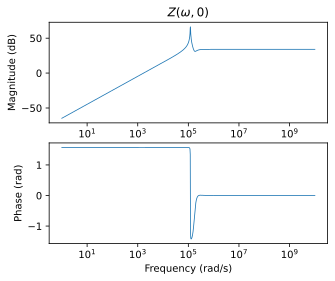

rad(Z0) = [ 1.5707963143905022 -1.4222099989654222 ]


In [109]:
plt.subplot(2, 1, 1)
plt.semilogx(w, 20 * np.log10(abs(Z0)))
plt.title('$Z(\omega, 0)$')
plt.ylabel('Magnitude (dB)')

plt.subplot(2, 1, 2)
plt.semilogx(w, np.angle(Z0))
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase (rad)')

plt.show()

print('rad(Z0) = [', max(np.angle(Z0)), min(np.angle(Z0)), "]")

**Task** : to synthesize $Z(\omega, z)$ and thus $\epsilon(\omega, z)$ across the line
**Idea**
1. Divide the TL into $N$ parts where $N=\lfloor\frac{L}{L_{strip}+S_{strip}}\rfloor$
2. Each part of the line can either have an open or a closed switch, thus each part has a constant $Z(\omega)$
3. We denote the $i^{th}$ part by $Z(\omega, i) \forall i\in[0, N-1]$
4. Denote by $Z_{in_i}$ the input impedance seen by the ith element. Thus $Z_{in_N}=Z_L$.  
Also denote $Z_{o_i}$. Thus, $Z_{o_0}=R_g$
5. Also denote $\Gamma_{L_i}$ and $\Gamma_{0_i}$

We start at the source. Then, we find the $\Gamma$ at the start of the element. Using this, we can find $\Gamma$ at the end of the element, which will be the $\Gamma$ at the start for the next element

In [110]:
l = Lstrip+Sstrip
N = int(L/l)

# $\epsilon(t)$ synthesis from $\Gamma(\omega, t)\Big|_{t=0}$

$\Gamma(\omega, 0)$ and $Z(\omega, L)$ are still the same